<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/PeriodicDomains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [2]:
# !rm *.py *.xml *.txt *.zip *.pvd *.vtu *.geo *.msh
try:
    from google.colab import files
except:
    print("This is not google.colab")
    
import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
    !sudo apt-get update
    !sudo apt-get install -y gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


This is not google.colab


DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


dolfin version: 2019.1.0


#Load pre-defined functions

In [0]:
import sympy as sp  
exists = os.path.isfile('DmriFemBuitInFunc.py')
isupdate = False
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemBuitInFunc.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/DmriFemBuitInFunc.py
from DmriFemBuitInFunc import *

# Working on the mesh

In [160]:
def CheckAndCorrectPeriodicity(mesh, direction, tol):
    print("Check and correct the periodicity in direction "+str(direction))
    bmesh  = BoundaryMesh(mesh, "exterior")   # surface boundary mesh
    gdim = mesh.geometry().dim()
    mesh_points=mesh.coordinates()
    bmesh_points=bmesh.coordinates()

    vertmap = bmesh.entity_map(0)

    xmin = bmesh_points[:, 0].min()
    xmax = bmesh_points[:, 0].max()

    ymin = bmesh_points[:, 1].min()
    ymax = bmesh_points[:, 1].max()

    zmin, zmax = 0, 0;
    if (gdim==3):
        zmin = bmesh_points[:, 2].min()
        zmax = bmesh_points[:, 2].max()

    if direction==0:
        cmin, cmax = xmin, xmax
    if direction==1:
        cmin, cmax = ymin, ymax
    if direction==2:
        cmin, cmax = zmin, zmax

    master=[];slave=[];

    for v in vertices(bmesh):
        global_vindex = vertmap[v.index()]
        x = bmesh_points[v.index()];
        x2 = 0;
        if (gdim==3):
            x2 = x[2]
        if abs(x[direction]-cmin)<tol:
            master.append((x[0],x[1],x2, global_vindex))
        if abs(x[direction]-cmax)<tol:
            slave.append((x[0],x[1],x2, global_vindex))

    if not(len(master)==len(slave)):
          print("The mesh is not periodic! The number of vertices on the opposite sides is not the same.");
          return 0;
        
    sorter = lambda x: (x[0], x[1], x[2])

    sorted_master = sorted(master)
    sorted_slave = sorted(slave)

    
    import numpy
    for i in range(0,3):
        if not(i==direction):
            masterX = list(zip(*sorted_master))[i]
            slaveX = list(zip(*sorted_slave))[i]
            error = abs(numpy.subtract(masterX, slaveX)).max()
            if (error>tol):
                print("The mesh is not periodic with the given tol="+str(tol))
      
    masterID = list(zip(*sorted_master))[3]
    slaveID = list(zip(*sorted_slave))[3] 

    for i in range(0,len(masterID)):
        for j in range(0,3):
          if not(j==direction):
              mesh_points[masterID[i]][j]=mesh_points[slaveID[i]][j]
          else:
              mesh_points[masterID[i]][j]=-mesh_points[slaveID[i]][j]

geo_choice = 2;

if geo_choice==1:
    mesh_name = "CirclesInSquare"

    is_partition_function_exist = os.path.isfile('GetPartitionMarkers.py')
    if is_partition_function_exist==False:
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/GetPartitionMarkers.py

    is_geo_file_exist = os.path.isfile(mesh_name+'.geo')  
    if is_geo_file_exist==False:
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/$mesh_name''.geo

    # Create mesh from geo file by gmsh
    !gmsh -2 $mesh_name''.geo -o $mesh_name''.msh

    # Convert .msh to .xml using dolfin-convert
    !dolfin-convert $mesh_name''.msh $mesh_name''.xml

    clear_output()

    mymesh = Mesh(mesh_name+".xml");  

    from GetPartitionMarkers import *

    GetPartitionMarkers(mesh_name+".msh", "pmk_"+mesh_name+".xml")

    partition_marker = MeshFunction("size_t", mymesh, mymesh.topology().dim())

    File("pmk_"+mesh_name+".xml")>>partition_marker

    cellmarker, phase, partition_marker, partion_list = Create_phase_func(mymesh, None, partition_marker)    

    File("Phase.pvd")<<phase
elif geo_choice==2:
    # clean files
    !rm *msh* *xml* *MAC*
    
    unzip_dir=!which unzip
    if len(unzip_dir)==0:
        !sudo apt-get install -y unzip

    # The periodic meshes were generated with Salome platform
    # ./runAppli -t -u /NOBACKUP/vdnguyen/SalomeMesh/SpheresInBox.py
    # The Salome script is available at
    # https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/SpheresInBox.py
    # TODO: The GMSH script for 3D does not work properly for now
    # https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/SpheresInBox.geo
    # but it should be fixed in the future
    
    # Download msh files and unzip
    !wget https://github.com/van-dang/MRI-Cloud/raw/mesh/SpheresInBox.msh.zip
    !wget https://github.com/van-dang/MRI-Cloud/raw/mesh/SpheresInBox_cmpt1.msh.zip  
    !unzip -q SpheresInBox.msh.zip
    !unzip -q SpheresInBox_cmpt1.msh.zip 
    
    # clear printscreen
    # clear_output()

    # convert msh to xml
    !dolfin-convert SpheresInBox.msh SpheresInBox.xml
    !dolfin-convert SpheresInBox_cmpt1.msh SpheresInBox_cmpt1.xml
    # create the phase function
    mymesh = Mesh("SpheresInBox.xml");  
    cmpt_mesh = Mesh('SpheresInBox_cmpt1.xml')
    cellmarker, phase, partition_marker, partion_list = Create_phase_func(mymesh, cmpt_mesh, None)
    File("Phase.pvd")<<phase
    
CheckAndCorrectPeriodicity(mymesh, 0, 1e-6)
CheckAndCorrectPeriodicity(mymesh, 1, 1e-6)
CheckAndCorrectPeriodicity(mymesh, 2, 1e-6)

rm: cannot remove '*MAC*': No such file or directory
--2019-07-11 21:12:09--  https://github.com/van-dang/MRI-Cloud/raw/mesh/SpheresInBox.msh.zip
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/SpheresInBox.msh.zip [following]
--2019-07-11 21:12:10--  https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/SpheresInBox.msh.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.84.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.84.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688270 (672K) [application/zip]
Saving to: ‘SpheresInBox.msh.zip’

SpheresInBox.msh.zi 100%[===================>] 672.14K  --.-KB/s    in 0.09s   

2019-07-11 21:12:10 (7.18 MB/s) - ‘SpheresInBox.msh.zip’ saved [688270/688270]

--2019-07-11

# Solve the Bloch-Torrey equation

Function Space for Single Domains has 2 components
(ur, ui): r-real, i-imaginary
Initialize peridodic function spaces.
The pseudo-periodic BCS are strongly imposed.
The mesh needs to be periodic.
t:   0.00  T: 20000.00 dt: 200.0 qvalue: 3.872983e-05 Completed 0.00%
t: 1000.00  T: 20000.00 dt: 200.0 qvalue: 3.872983e-05 Completed 4.95%
t: 2000.00  T: 20000.00 dt: 200.0 qvalue: 3.872983e-05 Completed 9.90%
t: 3000.00  T: 20000.00 dt: 200.0 qvalue: 3.872983e-05 Completed 14.85%
t: 4000.00  T: 20000.00 dt: 200.0 qvalue: 3.872983e-05 Completed 19.80%
t: 5000.00  T: 20000.00 dt: 200.0 qvalue: 3.872983e-05 Completed 24.75%
t: 6000.00  T: 20000.00 dt: 200.0 qvalue: 3.872983e-05 Completed 29.70%
t: 7000.00  T: 20000.00 dt: 200.0 qvalue: 3.872983e-05 Completed 34.65%
t: 8000.00  T: 20000.00 dt: 200.0 qvalue: 3.872983e-05 Completed 39.60%
t: 9000.00  T: 20000.00 dt: 200.0 qvalue: 3.872983e-05 Completed 44.55%
t: 10000.00  T: 20000.00 dt: 200.0 qvalue: 3.872983e-05 Completed 49.50%
t: 11000.00  T:

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


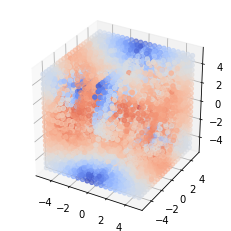

In [161]:
mri_simu = MRI_simulation()
mri_para = MRI_parameters()

bvalues = [1000]
for bvalue in bvalues:
    #################################################################################
    #########################  Pre-defined parameters ###############################
    mri_para.stype='PGSE'                                # sequence type
    mri_para.bvalue = bvalue;                            # bvalue
    mri_para.delta, mri_para.Delta = 10000, 10000           # time sequence
    mri_para.set_gradient_dir(mymesh, 1, 1, 1)           # gradient direction

    mri_para.T = mri_para.Delta+mri_para.delta
    mri_para.fs_sym = sp.Piecewise(
                    (  1., mri_para.s < mri_para.delta ),
                    (  0., mri_para.s < mri_para.Delta ),
                    ( -1., mri_para.s < mri_para.T ),
                    (  0., True )  
                ) 

    mri_para.Apply()
    mri_simu.k = 200;                                    # time-step size
    mri_simu.nskip = 5;                                  # frequency to print ouputs
    mydomain = MyDomain(mymesh, mri_para)
    # mydomain.phase = phase 
    mydomain.PeriodicDir = [1, 1, 1];             # Direction of the periodicity
    '''
    for pdir in range(0,3):
        if not(mydomain.PeriodicDir[pdir]==0):
            CheckAndCorrectPeriodicity(mymesh, pdir, 1e-6)
    '''
    
    mydomain.IsDomainPeriodic = True             # Confirm if the mesh if periodic
    mydomain.IsDomainMultiple = False              # Confirm if the mesh is multiple
    ################################################################################
    # mydomain.kappa_e_scalar = 5e-4;
    # mydomain.kappa = 1e-5;
    mydomain.Apply()   # Call Apply before setting the diffusion tensor
    ################################################################################
    # Impose the diffusion coefficient
    mydomain.D  = 3e-3;
    #################################################################################

    # linsolver = PETScLUSolver("mumps")
    linsolver = KrylovSolver("bicgstab")
    linsolver.parameters["absolute_tolerance"] = 1e-4
    linsolver.parameters["relative_tolerance"] = 1e-4
    linsolver.parameters["maximum_iterations"] = 10000
    
    mri_simu.solve(mydomain, mri_para, linsolver)

    Post_processing(mydomain, mri_para, mri_simu, plt)    